In [1]:
%matplotlib inline
from pylab import *
import sys
from collections import namedtuple
import random
import time

In [2]:
def exp_samples(lambd=1,n=1):
    """
    generates a numpy array of n samples distributed according to
    an exponential distribution with parameter λ
    """
    random.seed(time.time())
    return (-1/lambd)*log(rand(n))

def exp(lambd=1):
    """
    generates a sample distributed according to
    an exponential distribution with parameter λ
    """
    if lambd < 0:
        return inf()
    random.seed(time.time())
    return (-1/lambd)*log(rand())

def inf():
    return 9999

Customer = namedtuple("Customer", "service_time arrival_time patience_time")
# example: c = Customer(service_time = 1, time_remaining = 0.5, arrival_time = 2)

def printarray(a):
    print(np.around(a, 3))
    
def customer(service_time=inf(), arrival_time=-1, patience_time=inf()):
    return Customer(service_time=service_time, arrival_time=arrival_time, patience_time=patience_time)

In [361]:
# Example 2: M/M/c+M not PS (normal) queue (not necessarily) starting as empty


# N0 = starting number in the queue
# Tmax = time horizon

def Exercise2(arrival_rate_function, service_rate_function, patience_rate_function,
              number_of_servers_func, N0, Tmax):
    T             = [0]  # list of times that events occur
    t_temp        = 0    # temporary time to calculate delta
    N             = [N0]  # initial state of the system
    
    # customers currently being served by a server
    remaining_times = [customer(service_rate_func(), 0, inf())
                       for _ in range(min(number_of_servers_func(T[-1]), N0))]
    
    # customers that are waiting to be served by a server
    queue = [customer(inf(), 0, patience_rate_func())
             for _ in range(N0 - number_of_servers_func(T[-1]))]
    
    # times spent by users inside the system
    waiting_times = []
    
    # to calculate the probability someone has to wait in the queue
    p_wait_num = 0
    p_wait_denom = 0
    
    # first event must be an arrival
    next_arrival = arrival_rate_func(T[-1])
    if len(remaining_times) > 0:
        remaining_times.sort(key=lambda x: x.service_time, reverse=False)
        next_departure = remaining_times[0].service_time
    else:
        next_departure = inf()

    if len(queue) > 0:
        queue.sort(key=lambda x: x.patience_time, reverse=False)
        next_abandonment = queue[0].patience_time
    else:
        next_abandonment = inf()
    
    while T[-1] < Tmax:
        t_temp = T[-1]
        
        T.append(min(next_arrival, next_departure, next_abandonment))
            
        ##### ARRIVAL ##### 
        if T[-1] == next_arrival:
            N.append(N[-1]+1) 
            if len(remaining_times) < number_of_servers_func(T[-1]):
                service_time = service_rate_func()
                remaining_times.append(customer(T[-1] + service_time, T[-1], inf()))
            else:
                patience_time = patience_rate_func()
                queue.append(customer(inf(), T[-1], T[-1] + patience_time))
                p_wait_num += 1
            p_wait_denom+=1    
            next_arrival = T[-1] + arrival_rate_func(T[-1])
            #print("ARRIVAL %.3f departure %.3f abandonment %.3f" % (next_arrival, next_departure, next_abandonment))
        ##### DEPARTURE #####     
        elif T[-1] == next_departure:
            N.append(N[-1]-1)
            remaining_times.sort(key=lambda x: x.service_time, reverse=False)
            popped_customer = remaining_times.pop(0)
            T_in = popped_customer.arrival_time
            if T_in>0:
                waiting_times.append(T[-1] - T_in)            
            if len(queue) > 0:
                queue.sort(key=lambda x: x.arrival_time, reverse=False)
                next_to_enter = queue.pop(0)
                service_time = service_rate_func()
                remaining_times.append(customer(T[-1] + service_time, next_to_enter.arrival_time, inf()))
            #print("arrival %.3f DEPARTURE %.3f abandonment %.3f" % (next_arrival, next_departure, next_abandonment))
        ##### ABANDONMENT ##### 
        else: 
            N.append(N[-1]-1)
            queue.sort(key=lambda x: x.patience_time, reverse=False)
            popped_customer = queue.pop(0)
            T_in = popped_customer.arrival_time
            if T_in>0:
                waiting_times.append(T[-1] - T_in)
            #print("arrival %.3f departure %.3f ABANDONMENT %.3f" % (next_arrival, next_departure, next_abandonment))
        
        if len(remaining_times) > 0:
            remaining_times.sort(key=lambda x: x.service_time, reverse=False)
            next_departure = remaining_times[0].service_time
        else:
            next_departure = inf()

        if len(queue) > 0:
            queue.sort(key=lambda x: x.patience_time, reverse=False)
            next_abandonment = queue[0].patience_time
        else:
            next_abandonment = inf()

    # discard Tmax
    T = T[:-1] 
    N = N[:-1]
    return T, N, waiting_times, (p_wait_num)/(p_wait_denom)

The surge starts at 50 and ends at 80. We do not add any extra servers. Customers take a long time to abandon, which means that surge level is sustained.


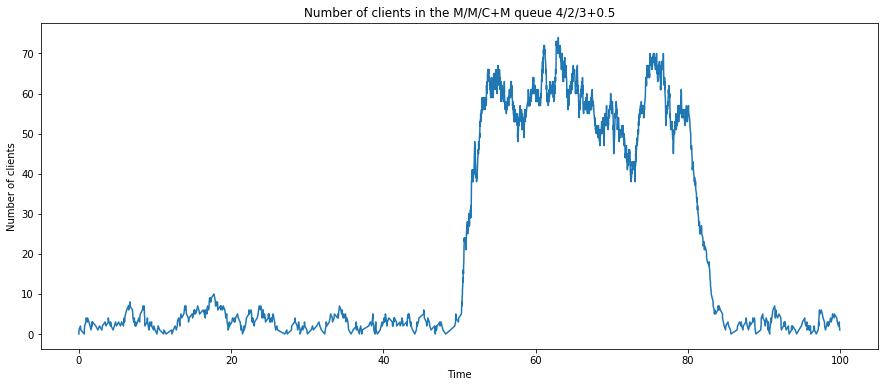

In [411]:
# PARAMETERS FOR EXAMPLE 2
# lambda = arrival rate, exponentially distributed
# mu = service rate, exponentially distributed
# gamma = patience rate, exponentially distributed
# c = number of servers

lambd = 4
mu = 2
gamma = 0.5
c = 3
N0 = 0
Tmax = 100

def arrival_rate_func(t_current):
    if t_current < 0.5 * Tmax or t_current > 0.8 * Tmax:
        return exp(lambd)
    return exp(8*lambd)

def service_rate_func():
    return exp(mu)

def patience_rate_func():
    return exp(gamma)

def number_of_servers_func(t_current):
    if t_current < 0.65 * Tmax or t_current > 0.85 * Tmax:
        return c
    return c

T, N, W, p_wait = Exercise2(arrival_rate_func, service_rate_func, patience_rate_func,
                            number_of_servers_func, N0, Tmax)
figure(figsize=(15,6))
plot(T, N)
xlabel('Time')
ylabel('Number of clients')
title('Number of clients in the M/M/C+M queue %d/%d/%d+%.1f' % (lambd, mu, c, gamma))
print("The surge starts at 50 and ends at 80. We do not add any extra servers. " + 
      "Customers take a long time to abandon, which means that surge level is sustained.")

The surge starts at 50 and ends at 80. We triple the servers between 65 and 85. Customers take a long time to abandon, which means that surge level is sustained.


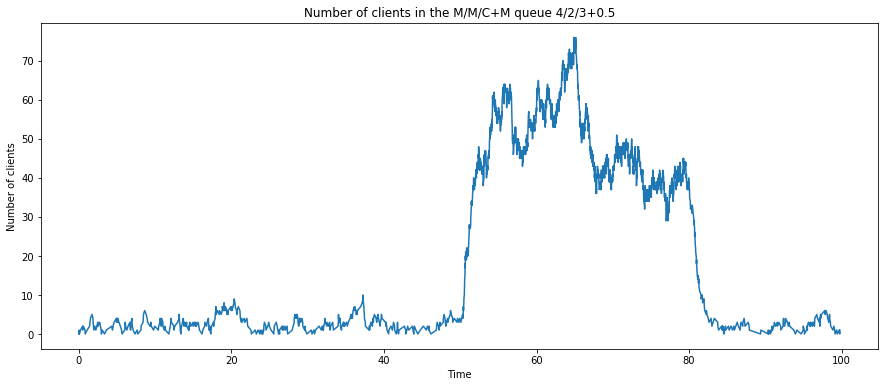

In [414]:
# PARAMETERS FOR EXAMPLE 2
# lambda = arrival rate, exponentially distributed
# mu = service rate, exponentially distributed
# gamma = patience rate, exponentially distributed
# c = number of servers

lambd = 4
mu = 2
gamma = 0.5
c = 3
N0 = 0
Tmax = 100

def arrival_rate_func(t_current):
    if t_current < 0.5 * Tmax or t_current > 0.8 * Tmax:
        return exp(lambd)
    return exp(8*lambd)

def service_rate_func():
    return exp(mu)

def patience_rate_func():
    return exp(gamma)

def number_of_servers_func(t_current):
    if t_current < 0.65 * Tmax or t_current > 0.85 * Tmax:
        return c
    return 3*c

T, N, W, p_wait = Exercise2(arrival_rate_func, service_rate_func, patience_rate_func,
                            number_of_servers_func, N0, Tmax)
figure(figsize=(15,6))
plot(T, N)
xlabel('Time')
ylabel('Number of clients')
title('Number of clients in the M/M/C+M queue %d/%d/%d+%.1f' % (lambd, mu, c, gamma))
print("The surge starts at 50 and ends at 80. We triple the servers between 65 and 85. " + 
      "Customers take a long time to abandon, which means that surge level is sustained.")

The surge starts at 50 and ends at 80. We triple the servers between 65 and 85. Abandonment rate = Service rate, which means that surge level is not as high.


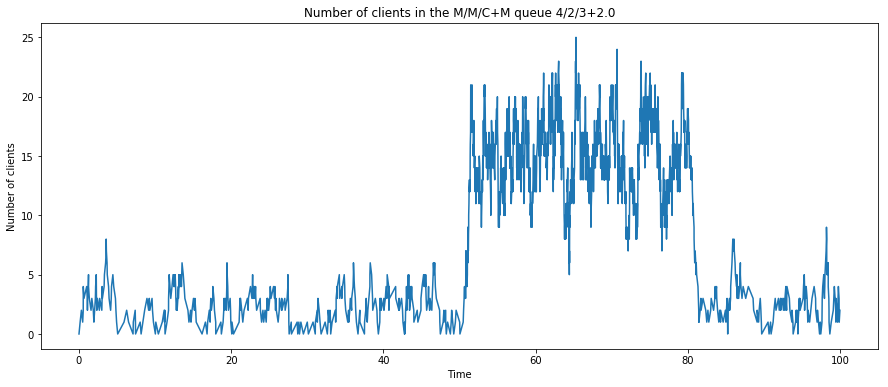

In [420]:
# PARAMETERS FOR EXAMPLE 2
# lambda = arrival rate, exponentially distributed
# mu = service rate, exponentially distributed
# gamma = patience rate, exponentially distributed
# c = number of servers

lambd = 4
mu = 2
gamma = 2
c = 3
N0 = 0
Tmax = 100

def arrival_rate_func(t_current):
    if t_current < 0.5 * Tmax or t_current > 0.8 * Tmax:
        return exp(lambd)
    return exp(8*lambd)

def service_rate_func():
    return exp(mu)

def patience_rate_func():
    return exp(gamma)

def number_of_servers_func(t_current):
    if t_current < 0.65 * Tmax or t_current > 0.85 * Tmax:
        return c
    return 3*c

T, N, W, p_wait = Exercise2(arrival_rate_func, service_rate_func, patience_rate_func,
                            number_of_servers_func, N0, Tmax)
figure(figsize=(15,6))
plot(T, N)
xlabel('Time')
ylabel('Number of clients')
title('Number of clients in the M/M/C+M queue %d/%d/%d+%.1f' % (lambd, mu, c, gamma))
print("The surge starts at 50 and ends at 80. We triple the servers between 65 and 85. " + 
      "Abandonment rate = Service rate, which means that surge level is not as high.")

In [373]:
def E_C(rho, c):
    v1  = rho**c / math.factorial(c)
    v2  = c / (c - rho)
    v3 = sum([rho**k / math.factorial(k) for k in range(c)])
    Num = v1 * v2
    Den = v3 + (v1 * v2)
    return Num / Den

def avg_num_in_system(rho, c):
    a1 = rho / (c - rho)
    ec = E_C(rho, c)
    return a1*ec + rho

In [328]:
print("Testing with no abandonment")
lambd = 4
mus = [2, 4, 5, 8]
rhos = [2, 1, 0.8, 0.5]
servers = [15, 3]
for i in range(4):
    T, N, W, p_wait = Exercise2(lambd, mus[i], -1, servers[1], 0, Tmax=2000)
    print("P(waiting) %.3f vs. Erlang C %.3f" % (p_wait, E_C(rhos[i], servers[1])))
_, N, W, p_wait = Exercise2(4, 4, -1, servers[0], 0, Tmax=2000)
print("P(waiting) %.3f vs. Erlang C %.3f" % (p_wait, E_C(1, servers[0])))

Testing with no abandonment
P(waiting) 0.463 vs. Erlang C 0.444
P(waiting) 0.102 vs. Erlang C 0.091
P(waiting) 0.066 vs. Erlang C 0.052
P(waiting) 0.027 vs. Erlang C 0.015
P(waiting) 0.000 vs. Erlang C 0.000
